## Load Raw Data

In [4]:
import mne
import numpy as np
import os
from pathlib import Path

root_dir = Path("/Volumes/Public/data_keri")
mne.set_log_level('ERROR')  # 或 'ERROR'
# 匹配所有 *_EC.set 和 *_EO.set 文件
set_files = list(root_dir.rglob("*_EC.set")) + list(root_dir.rglob("*_EO.set"))

# 正确排除包含 "Unused" 的路径
set_files = [f for f in set_files if "Unused AB" not in f.parts]

print(f"Find {len(set_files)} Files")

Find 142 Files


In [5]:
from tqdm import tqdm
# 先收集所有 label
labels_found = set()
for file_path in set_files:
    label = file_path.parent.parent.parent.name
    labels_found.add(label)

# 建立 label 映射
label_mapping = {lbl: idx for idx, lbl in enumerate(sorted(labels_found))}
print("Label mapping:", label_mapping)

# 存储所有数据
X_all = []
y_all = []

for file_path in tqdm(set_files, desc="Processing files"):
    raw = mne.io.read_raw_eeglab(str(file_path), preload=True)

    # 提取 label
    label = file_path.parent.parent.parent.name
    label_idx = label_mapping[label]

    # picks
    picks = mne.pick_types(raw.info, eeg=True, exclude='bads')
    raw.pick(picks)

    # average reference
    raw.set_eeg_reference('average')

    # filter
    raw.filter(1., 40., fir_design='firwin')

    # epoch
    epoch_length = 1.0
    epochs = mne.make_fixed_length_epochs(
        raw,
        duration=epoch_length,
        overlap=0.0,
        preload=True,
        reject_by_annotation=True
    )
    data = epochs.get_data()   # (n_epochs, n_channels, n_times)

    # z-score per epoch
    mean = data.mean(axis=-1, keepdims=True)
    std = data.std(axis=-1, keepdims=True)
    data = (data - mean) / std

    # save
    X_all.append(data)
    y_all.append(np.full((data.shape[0],), label_idx))

# 合并所有 subject
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

print("Final shape:", X_all.shape)
print("Labels shape:", y_all.shape)


np.savez("preprocessed_data.npz", X=X_all, y=y_all)
print("Dataset Svaed as preprocessed_data.npz")

Label mapping: {'AB': 0, 'PdP': 1, 'PnP': 2, 'PwP': 3}


Processing files: 100%|██████████| 142/142 [00:13<00:00, 10.24it/s]


Final shape: (17060, 64, 256)
Labels shape: (17060,)
Dataset Svaed as preprocessed_data.npz


## Load Preprocessed Data

Sample tensor shape: torch.Size([1, 64, 1280])


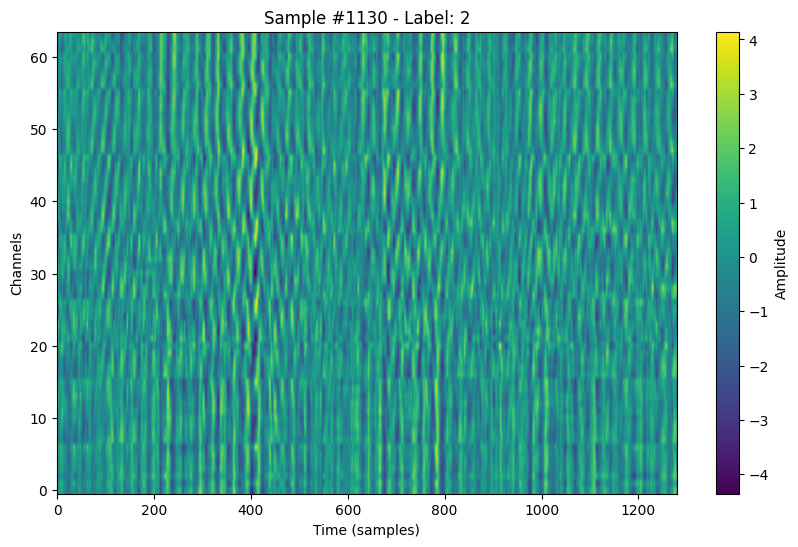

(3346, 64, 1280) (3346,)
Train: 2342, Val: 501, Test: 503
Batch shape: torch.Size([64, 1, 64, 1280])


In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np

# 载入预处理好的数据
data = np.load("preprocessed_data.npz")
X_all = data["X"]
y_all = data["y"]



# 随机选一个样本
i = np.random.randint(0, len(X_all))
sample = X_all[i]       # shape: (64, 256)
label = y_all[i]

# 如果你要喂给 CNN，一般需要加 channel 维度
# (1, 64, 256)
sample_tensor = torch.from_numpy(sample).float().unsqueeze(0)

print("Sample tensor shape:", sample_tensor.shape)

# 可视化：
plt.figure(figsize=(10, 6))
plt.imshow(sample, aspect="auto", cmap="viridis", origin="lower")
plt.colorbar(label='Amplitude')
plt.xlabel("Time (samples)")
plt.ylabel("Channels")
plt.title(f"Sample #{i} - Label: {label}")
plt.show()



print(X_all.shape, y_all.shape) 
# 转为 Tensor，并调整 shape：增加通道维度
X_tensor = torch.from_numpy(X_all).float().unsqueeze(1)
y_tensor = torch.from_numpy(y_all).long()

# 创建 TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# 划分数据集
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")

X_train = torch.cat([x for x, _ in train_set], dim=0)

X_train = X_train.squeeze(1)

# 按 channel 做 mean/std
mean = X_train.mean(dim=(0, 2))       
std = X_train.std(dim=(0, 2)) + 1e-6  

# 标准化
def standardize(dataset, mean, std):
    X_list, y_list = [], []
    for x, y in dataset:
        # x shape: (1, 64, 256)
        x_ = x.clone()
        x_[0] = (x_[0] - mean[:, None]) / std[:, None]  # x_[0] shape: (64, 256)
        X_list.append(x_)
        y_list.append(y)
    X_final = torch.stack(X_list, dim=0)  # shape: (N, 1, 64, 256)
    y_final = torch.tensor(y_list)
    return TensorDataset(X_final, y_final)


train_set = standardize(train_set, mean, std)
val_set = standardize(val_set, mean, std)
test_set = standardize(test_set, mean, std)

# 创建 DataLoader
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# 验证
for xb, yb in train_loader:
    print("Batch shape:", xb.shape)
    break

## Model Defination

In [7]:
import torch.nn as nn

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

class SeparableConv2d(nn.Module):
    """
    PyTorch implementation of Keras's SeparableConv2D.
    """

    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   groups=in_channels, bias=bias, padding=padding)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))
    

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y
    



class EEGNet(nn.Module):
    def __init__(self, nb_classes, Chans=64, Samples=256,
                 dropoutRate=0.5, kernLength=256, F1=96,
                 D=1, F2=96, dropoutType='Dropout'):
        super(EEGNet, self).__init__()

        if dropoutType == 'SpatialDropout2D':
            self.dropout_layer = nn.Dropout2d
        elif dropoutType == 'Dropout':
            self.dropout_layer = nn.Dropout
        else:
            raise ValueError("dropoutType must be 'SpatialDropout2D' or 'Dropout'")

        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernLength), padding=(0, kernLength // 2), bias=False),
            nn.BatchNorm2d(F1),
            nn.Conv2d(F1, F1 * D, (Chans, 1), groups=F1, bias=False), 
            nn.BatchNorm2d(F1 * D),
            nn.GELU(),
            nn.AvgPool2d((1, 4)),
            self.dropout_layer(dropoutRate)
        )
        self.depthwise_conv = self.block1[2]

        # Block 2
        self.block2 = nn.Sequential(
            SeparableConv2d(F1 * D, F2, (1, 16), padding=(0, 8), bias=False),
            nn.BatchNorm2d(F2),
            nn.GELU(),
            nn.AvgPool2d((1, 8)),
            self.dropout_layer(dropoutRate)
        )

        self.attention = SEBlock(F2)

        # Classifier
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, Chans, Samples)
            output_size = self._forward_features(dummy_input).shape[1]

        self.classifier = nn.Linear(output_size, nb_classes)

    def _forward_features(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.attention(x)
        return torch.flatten(x, 1)

    def forward(self, x):
        features = self._forward_features(x)
        return self.classifier(features)

    def apply_constraints(self):
        # Apply max-norm constraint on the depthwise convolution weights
        self.depthwise_conv.weight.data = torch.renorm(
            self.depthwise_conv.weight.data, p=2, dim=0, maxnorm=1.0
        )

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Performs one full training pass."""
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Apply constraints after each weight update
        if hasattr(model, 'apply_constraints'):
            model.apply_constraints()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    """Performs evaluation on a dataset."""
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return val_loss / total, correct / total

## Model configration

In [15]:
num_classes = len(np.unique(y_all))

model = EEGNet(
    nb_classes=num_classes,
    Chans=64,
    Samples=1280,
    dropoutRate=0.3,
    kernLength=64,
    F1=8,
    D=2,
    F2=16,
    dropoutType='Dropout'
)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

for xb, yb in train_loader:
    print(xb.shape)
    break

Using device: mps
torch.Size([64, 1, 64, 1280])


## Train Loop

In [16]:
model = model.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

history = {
    "loss": [],
    "accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

# 开始训练
num_epochs = 100
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # 存 history
    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)

    print(f"Epoch {epoch:02d}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # 保存最优模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")

# 加载最优模型再测试
model.load_state_dict(torch.load("best_model.pt"))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

Epoch 01: Train Loss=1.3801, Train Acc=0.2869, Val Loss=1.3601, Val Acc=0.3473
Epoch 02: Train Loss=1.3139, Train Acc=0.3933, Val Loss=1.2636, Val Acc=0.4012


KeyboardInterrupt: 

## Plot

Generating and saving loss plot...


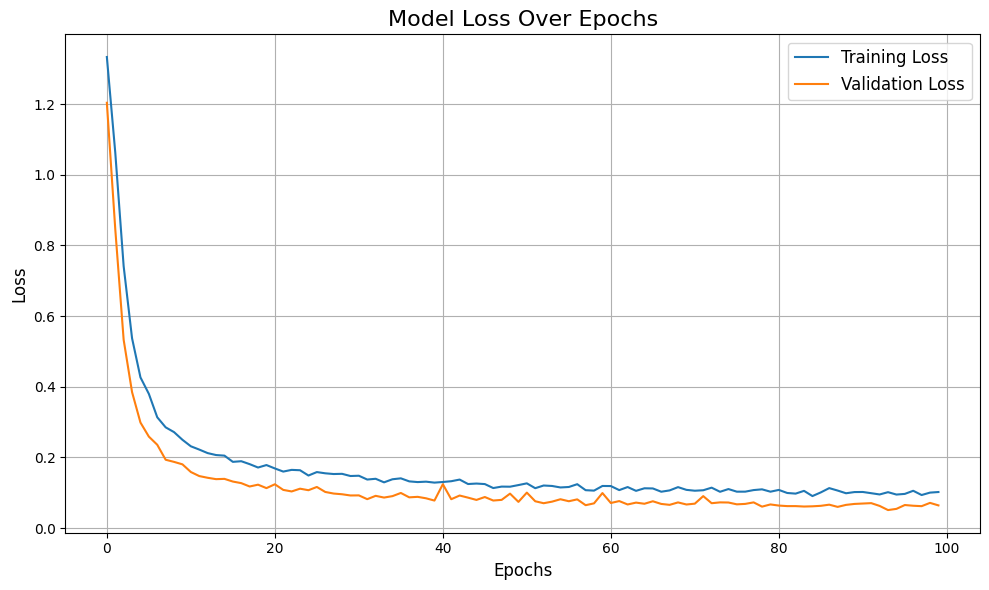

Loss plot saved to plots/loss_plot.svg

Generating and saving accuracy plot...


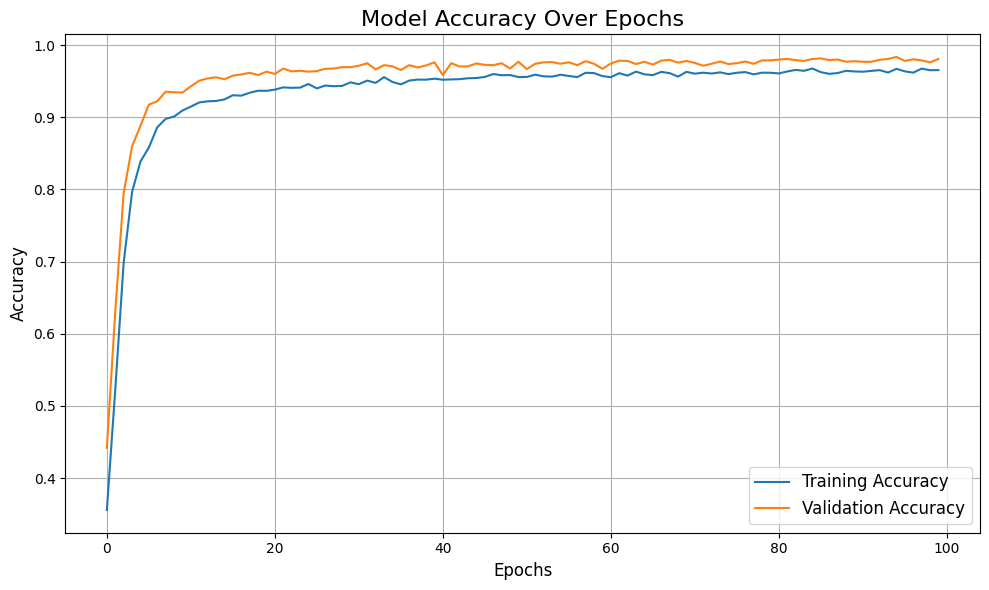

Accuracy plot saved to plots/accuracy_plot.svg

Generating and saving confusion matrix...


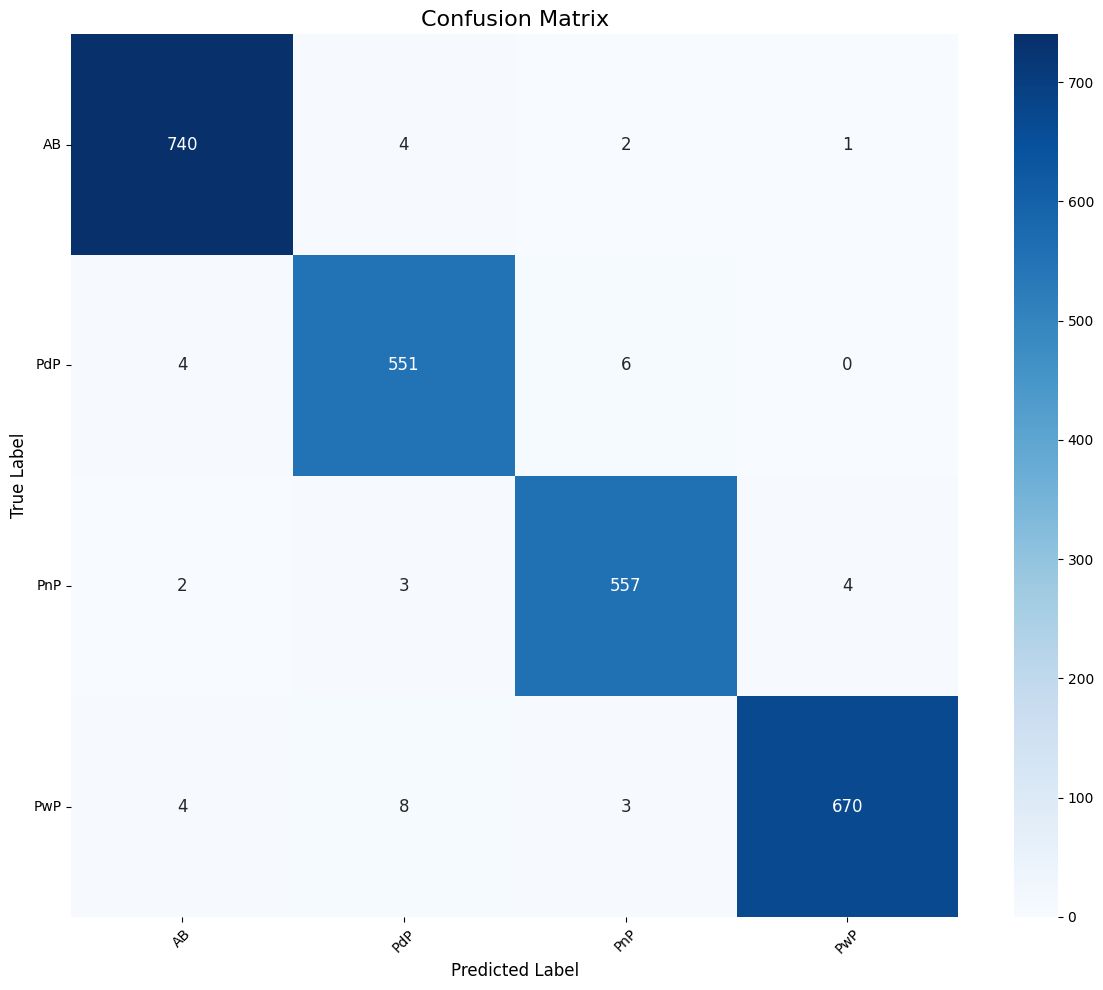

Confusion matrix saved to plots/confusion_matrix.svg


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import os

# This script assumes 'history', 'model', 'test_loader', 'device', and
# 'nb_classes' are available from the preceding training script.

# Define a directory to save the plots
output_dir = "plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ==============================================================================
# 1. Plot Loss and Save as SVG
# ==============================================================================
print("Generating and saving loss plot...")
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
loss_filename = os.path.join(output_dir, "loss_plot.svg")
plt.savefig(loss_filename, format='svg')
plt.show()
print(f"Loss plot saved to {loss_filename}")


# ==============================================================================
# 2. Plot Accuracy and Save as SVG
# ==============================================================================
print("\nGenerating and saving accuracy plot...")
plt.figure(figsize=(10, 6))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
accuracy_filename = os.path.join(output_dir, "accuracy_plot.svg")
plt.savefig(accuracy_filename, format='svg')
plt.show()
print(f"Accuracy plot saved to {accuracy_filename}")


# ==============================================================================
# 3. Plot Confusion Matrix and Save as SVG
# ==============================================================================
print("\nGenerating and saving confusion matrix...")

@torch.no_grad()
def get_all_preds(model, loader, device):
    """Function to get all predictions and labels from a dataloader."""
    model.eval()
    all_preds = torch.tensor([], dtype=torch.long).to(device)
    all_labels = torch.tensor([], dtype=torch.long).to(device)

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)

    return all_preds.cpu().numpy(), all_labels.cpu().numpy()

# Get predictions and true labels
y_pred, y_true = get_all_preds(model, test_loader, device)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class names for plotting
class_names = ['AB', 'PdP', 'PnP', 'PwP']

# Create a new figure for the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 12})

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
cm_filename = os.path.join(output_dir, "confusion_matrix.svg")
plt.savefig(cm_filename, format='svg')
plt.show()
print(f"Confusion matrix saved to {cm_filename}")

